In [33]:
import pandas as pd
result_path = "set your result path here"
res = pd.read_csv(result_path)
res = res.T
res.columns = res.iloc[0]
res = res[1:]
res["gameability"] = (res["Verboisty Gameability"] + res["Conciseness Gameability"]) / 2

/var/folders/2h/1h16rrxx1mvcbyd70jx8_vx40000gn/T/ipykernel_2990/1781176105.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])  # 调整以给右侧小热图留出空间


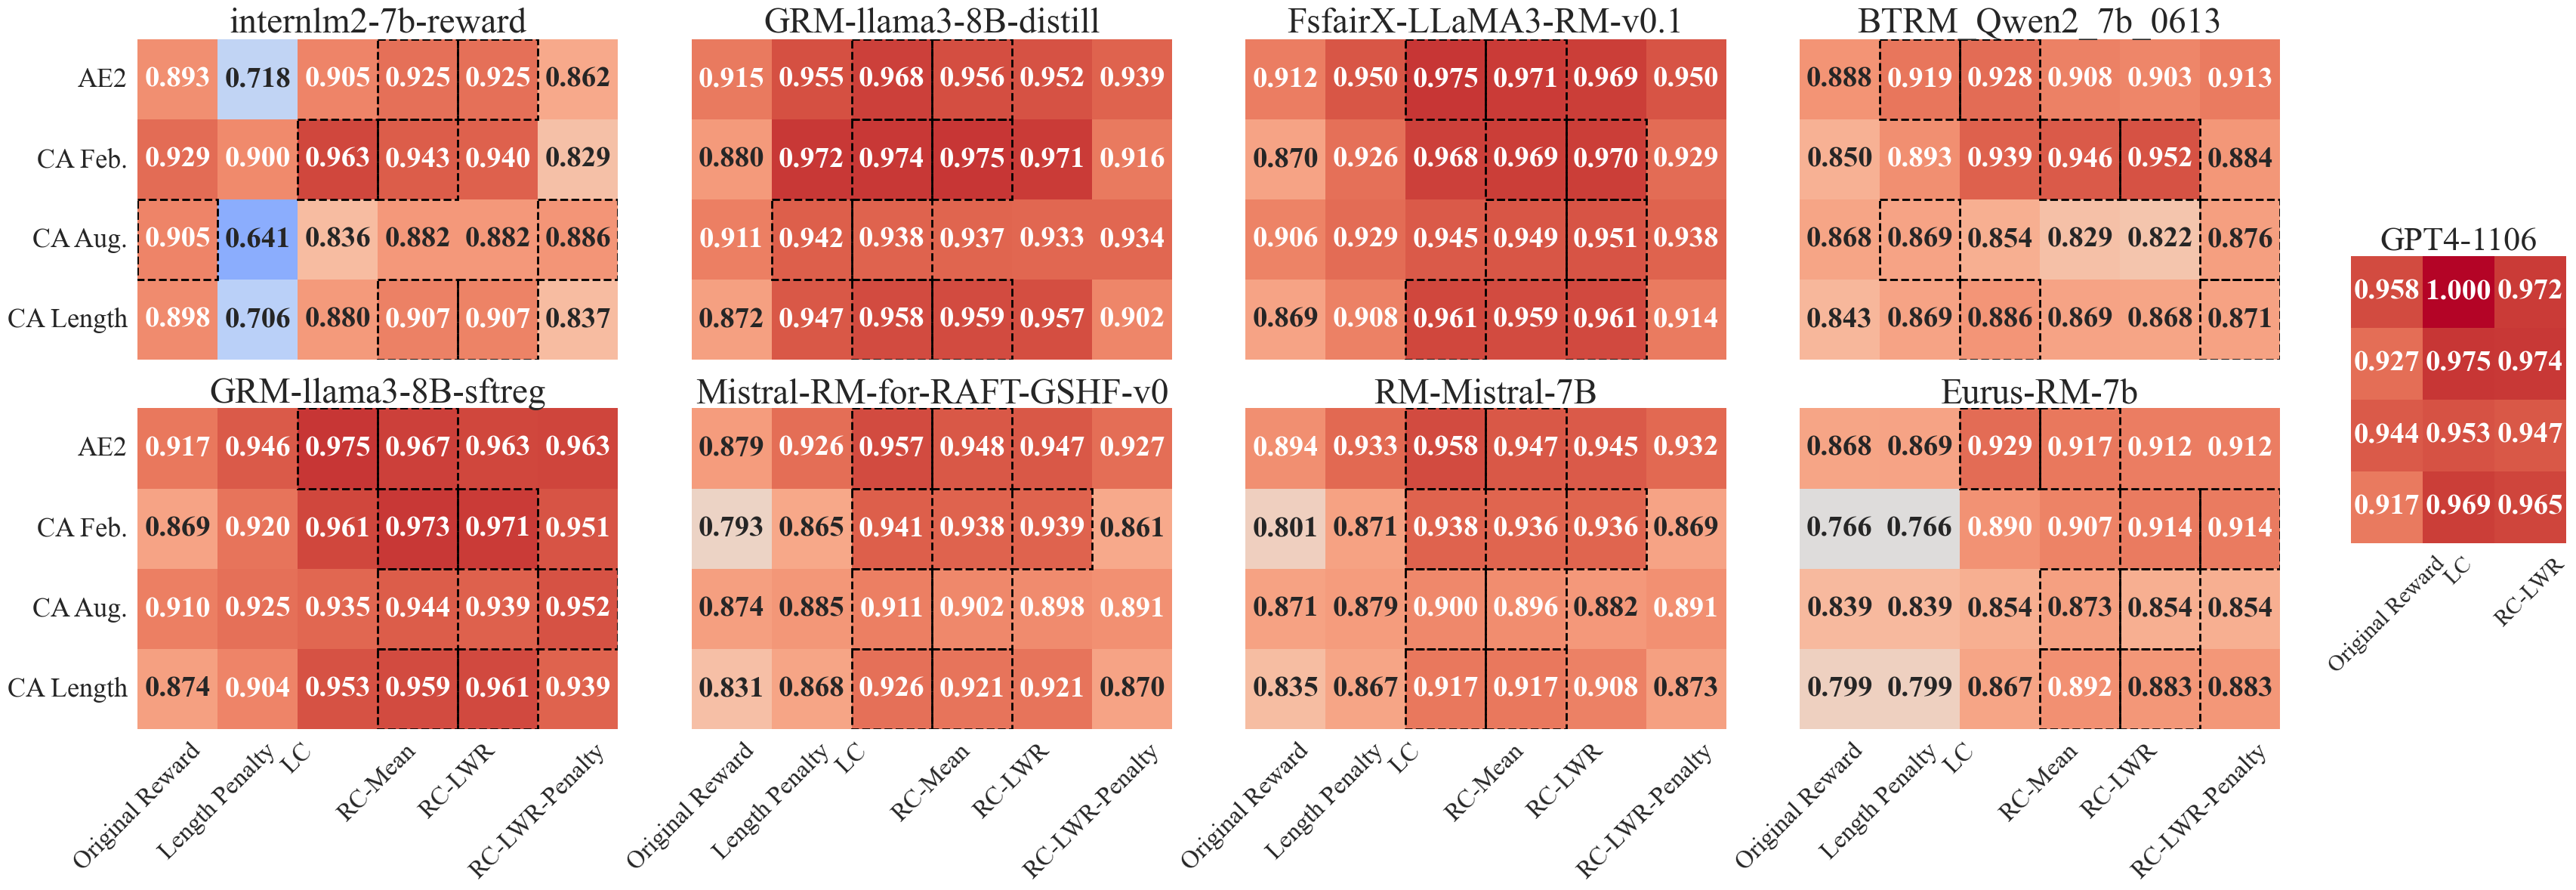

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np

# 模拟数据（请换成你的实际数据）
sns.set(style="whitegrid", font='Times New Roman')
corr_res = res[~res.index.str.contains("Unnamed")]
corr_res = corr_res.drop(columns=["Verboisty Gameability", "Conciseness Gameability", "gameability"])
corr_res = corr_res.drop(columns=["spearman_ChatbotArena Jun.", "spearman_ChatbotArena Jul.", "spearman_ChatbotArena Both", "spearman_ChatbotArena MD"])
# drop all columns with the name beginning with kendall
corr_res = corr_res.drop(columns=[col for col in corr_res.columns if "kendall" in col.lower()])
corr_res = corr_res.T
unused_models = ["internlm2-20b-reward", "Llama-3-OffsetBias-RM-8B"]
unused_models = []

model_names = [
    # "internlm2-20b-reward",
    # "Llama-3-OffsetBias-RM-8B",
    "internlm2-7b-reward",
    "GRM-llama3-8B-distill",
    "FsfairX-LLaMA3-RM-v0.1", 
    "BTRM_Qwen2_7b_0613", 
    "GRM-llama3-8B-sftreg",
    "Mistral-RM-for-RAFT-GSHF-v0",
    "RM-Mistral-7B",
    "Eurus-RM-7b", 
]

# 清理并处理数据
with_penalty = True
if not with_penalty:
    corr_res = corr_res.drop(columns=[col for col in corr_res.columns if "penalty" in col.lower()])
corr_res = corr_res.drop(columns=[col for col in corr_res.columns if "discrete" in col])
corr_res = corr_res.drop(columns=[col for col in corr_res.columns if "gpt" in col and "LC" not in col])

fig, axes = plt.subplots(2, len(model_names) // 2, figsize=(38, 12), sharex=True, sharey=True)

vmin = corr_res.min().min()
vmax = corr_res.max().max()

cmap_main = "coolwarm"
cmap_gpt = "coolwarm"


for ax, model_name in zip(axes.flatten(), model_names):
    model_res = corr_res.filter(like=model_name, axis=1)
    model_res.columns = model_res.columns.str.replace(f"{model_name}-", "")
    model_res.columns = model_res.columns.str.replace(model_name, "Original Reward")
    model_res.columns = model_res.columns.str.replace("LC", "Length Control")
    
    model_res.index = model_res.index.str.replace("spearman_", "")
    model_res.index = model_res.index.str.replace("ChatbotArena", "CA")
    model_res.index = model_res.index.str.replace("AlpacaEval", "AE")
    # print(model_res.columns)
    model_res = model_res[["Original Reward", "Penalty", "Length Control", "MeanReward", "LOWESS", "LOWESS-Penalty"]]
    rename_dict = {
        "Original Reward": "Original Reward", 
        "Penalty": "Length Penalty", 
        "Length Control": "LC",
        "MeanReward": "RC-Mean", 
        "LOWESS": "RC-LWR", 
        "LOWESS-Penalty": "RC-LWR-Penalty"
    }
    model_res.rename(columns=rename_dict, inplace=True)
    
    sns.heatmap(model_res.astype(float), annot=True, fmt=".3f", cmap=cmap_main, 
                cbar=False, vmin=vmin, vmax=vmax, ax=ax, square=True,
                annot_kws={"size": 28, "weight": "bold"})
    
    for y in range(model_res.shape[0]):
        cols_sorted = model_res.iloc[y].sort_values(ascending=False).index
        max_col_idx = model_res.columns.get_loc(cols_sorted[0])  # 最大值
        second_max_col_idx = model_res.columns.get_loc(cols_sorted[1])  # 第二大值

        max_val_pos = (y, max_col_idx)
        second_max_val_pos = (y, second_max_col_idx)
        
        for pos in [max_val_pos, second_max_val_pos]:
            rect = Rectangle((pos[1], pos[0]), 1, 1, fill=False, edgecolor='black', linewidth=2.0, linestyle='--')
            ax.add_patch(rect)
    
    ax.set_ylabel('')
    
    ax.set_xticks(range(len(model_res.columns)))
    ax.set_xticklabels(model_res.columns, rotation=45, ha='center', fontsize=24)
    ax.set_yticklabels(model_res.index, rotation=0, ha='right', fontsize=26)

    ax.set_title(f"{model_name}", fontsize=34)
    
data = {
    'Original Reward': [0.9581, 0.92676, 0.944469, 0.91653],
    'LC': [1.0, 0.975286, 0.95316, 0.96897],
    'RC-LWR': [0.9715, 0.9736, 0.9468, 0.9647]
}
index = ['AE2', 'CA Feb.', 'CA Jul.', 'CA Length']
gpt_res = pd.DataFrame(data, index=index)

new_ax = fig.add_axes([0.82, 0.3, 0.075, 0.5])
sns.heatmap(gpt_res, annot=True, fmt=".3f", cmap=cmap_gpt, cbar=False, ax=new_ax, vmin=vmin, vmax=vmax, square=True,
            annot_kws={"size": 28, "weight": "bold"})
new_ax.set_ylabel('')
new_ax.set_yticks([])
new_ax.set_xticklabels(gpt_res.columns, rotation=45, ha='center', fontsize=22)
new_ax.set_title("GPT4-1106", fontsize=32)

plt.tight_layout(rect=[0, 0, 0.8, 1]) 
plt.show()
